<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.Restaurant-Revenue-Prediction/blob/main/4.model_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
from google.colab import drive
import os
import pandas as pd
import numpy as np

In [2]:
# PEP 8
%%capture
!pip install pycodestyle
!pip install --index-url https://test.pypi.org/simple/ nbpep8

from nbpep8.nbpep8 import pep8

# Import module files

In [3]:
%%capture
git_download_path = \
'https://raw.githubusercontent.com/PashaIanko/Kaggle.Restaurant-Revenue-Prediction/main/'

files = [
    'path_manager.py',
    'model.py',
    'sklearn_utils.py'
]


def download_files(dict_):
    for file, url in dict_.items():
        !wget -O {file} {url} {file}


download_files(
    {
        file: git_download_path + file
        for file in files
    }
)

pep8(_ih)

In [4]:
import importlib
import path_manager
import sklearn_utils
import model

def reload_all(modules):
    for module in modules:
        importlib.reload(module)

reload_all(
    [
        path_manager,
        model,
        sklearn_utils
    ]
)

from path_manager import PathManager
from sklearn_utils import print_model_cv_scores
from sklearn_utils import plot_cv_results
from sklearn_utils import dict_subset

# Setup paths

In [5]:
drive.mount('/content/gdrive')
gdrive_path = '/content/gdrive/MyDrive/'

COMPETITION_PATH = gdrive_path + 'ML/Competitions/5.RestaurantRevenue/'
PREPROC_TRIAL = 2
MODELS_TRIAL = 2

pep8(_ih)

Mounted at /content/gdrive



In [6]:
manager = PathManager(
    competition_path=COMPETITION_PATH,
    preprocessing_trial=PREPROC_TRIAL,
    models_trial=MODELS_TRIAL
)

pep8(_ih)

# Download models

In [7]:
models = manager.load_models(
    [
        'SVM_final',
        'ElasticNet_final'
    ]
)

In [8]:
models

{'SVM_final': SVR(C=0.7000000000000001, gamma='auto'),
 'ElasticNet_final': ElasticNet(alpha=0.1, l1_ratio=0.1, random_state=42)}

# Download data

In [9]:
df_test = pd.read_csv(
    os.path.join(
        manager.data_trial_path,
        'test_processed.csv'
    ),
    index_col=[0]
)

# subsample from train.csv for testing
df_test_sample = pd.read_csv(
    os.path.join(
        manager.data_trial_path,
        'test_sample_processed.csv'
    ),
    index_col=[0]
)

df_trainval = pd.read_csv(
    os.path.join(
        manager.data_trial_path,
        'trainval_sample_processed.csv'
    ),
    index_col=[0]
)

X_train_val = df_trainval.values[:, :-1]
Y_train_val = df_trainval.values[:, -1]

X_test_sample = df_test_sample.values[:, :-1]
Y_test_sample = df_test_sample.values[:, -1]

# Cross validation performance for final models

In [10]:
_ = print_model_cv_scores(
    models,
    X_=X_train_val,
    Y_=Y_train_val,
    cv_=7,
    scoring_='neg_mean_squared_error'
)

Model: ElasticNet_final, mean: -0.22238430217090185, std: 0.09773385412604917
Model: SVM_final, mean: -0.2053489009225662, std: 0.08625756347037801


# Cross validation metrics (check possible overfit)

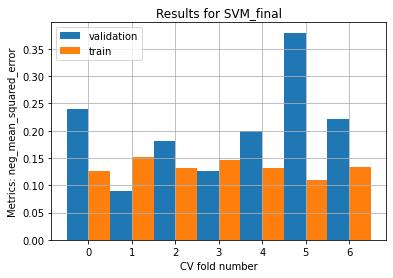

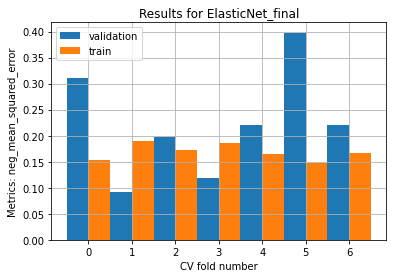

In [11]:
_ = plot_cv_results(
    models,
    X_=X_train_val,
    Y_=Y_train_val,
    cv_=7,
    scoring_='neg_mean_squared_error',
    to_put_minus_=True
)

# Report test sample performance

In [12]:
final_model = models['SVM_final']

final_model.fit(
    X_train_val,
    Y_train_val
)

SVR(C=0.7000000000000001, gamma='auto')

In [13]:
from sklearn.metrics import mean_squared_error


test_sample_predictions = final_model.predict(X_test_sample)
test_result = mean_squared_error(
    test_sample_predictions,
    Y_test_sample
)
print(test_result)

pep8(_ih)

0.1786080255328391



# Retraining on all available data

In [14]:
final_arr = np.vstack([X_train_val, X_test_sample])
final_target = np.hstack([Y_train_val, Y_test_sample])
final_arr.shape,  final_target.shape

((137, 43), (137,))

In [15]:
final_model.fit(
    final_arr,
    final_target
)

SVR(C=0.7000000000000001, gamma='auto')

# Submission and saving final model

In [16]:
df_test.head(2)

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,0.995545,-1.032819,-0.285964,-0.26814,-0.383325,-0.807152,-0.633614,-0.182156,-0.619713,-0.217343,...,-0.497002,-0.606797,-0.556056,-0.652386,0.0,0.0,1.0,0.0,0.020451,0.693147
1,0.995545,-0.334236,-0.285964,-0.26814,-0.383325,0.014161,-0.633614,-0.182156,-1.176974,-0.790338,...,-0.497002,-0.606797,-0.556056,-0.652386,0.0,0.0,0.0,1.0,0.138344,0.693147


In [17]:
# Remove target (that was artificially created during data processing pipeline)
submission_data = df_test.values[:, :-1]
submission_data.shape

(100000, 43)

In [18]:
final_predictions = np.exp(
    final_model.predict(submission_data)
)

In [19]:
df_submission = pd.DataFrame(final_predictions, columns=['Prediction'])
df_submission.index.rename('Id', inplace=True)
df_submission.head()

,Prediction
Id,
0,4.198061e+06
1,3.066032e+06
2,3.975463e+06
3,3.279833e+06
4,4.861614e+06


In [20]:
final_model_name = 'SVM_final_retrained'

submission_path = os.path.join(
    manager.models_trial_path,
    final_model_name,
    'submission.csv'
)

manager.save_models(
    {
        final_model_name: final_model
    }
)
df_submission.to_csv(submission_path)